In [1]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 13
matplotlib.rcParams['text.color'] = 'k'

In [60]:
df = pd.read_csv("C:\\Users\\M4\\Downloads\\Compressed\\AEP_hourly.csv")
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df = df.set_index('Date')
df = df['2016-01-02':'2018-8-29'].resample('W').sum()
df.head()

,AEP_Consumption
Date,
2016-01-03,698536
2016-01-10,2717863
2016-01-17,2863882
2016-01-24,3156518
2016-01-31,2695143


In [3]:
df

,AEP_Consumption
Date,
2016-01-03,698536
2016-01-10,2717863
2016-01-17,2863882
2016-01-24,3156518
2016-01-31,2695143
...,...
2018-07-08,2707980
2018-07-15,2799780
2018-07-22,2616533


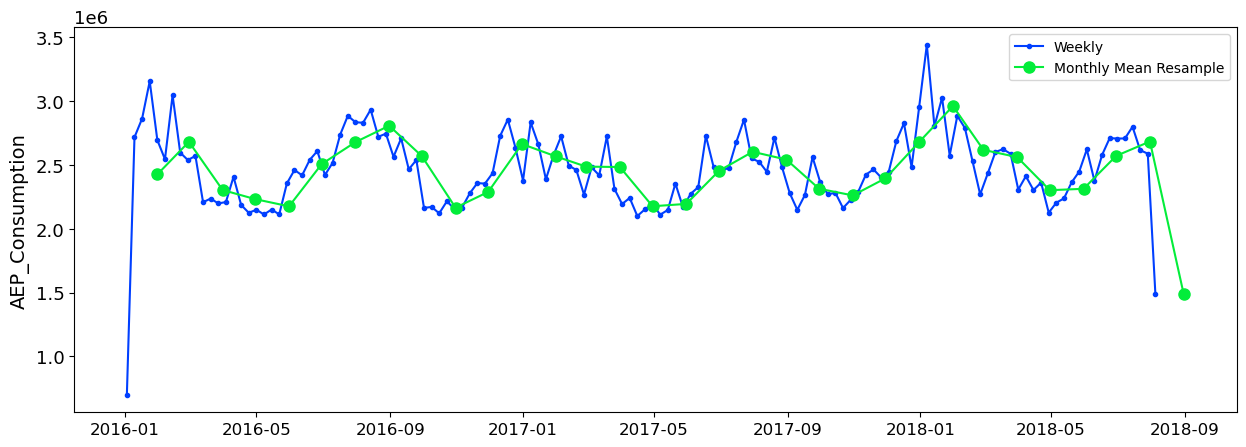

In [4]:
y = df['AEP_Consumption']
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y,marker='.', linestyle='-', label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('AEP_Consumption')
ax.legend();

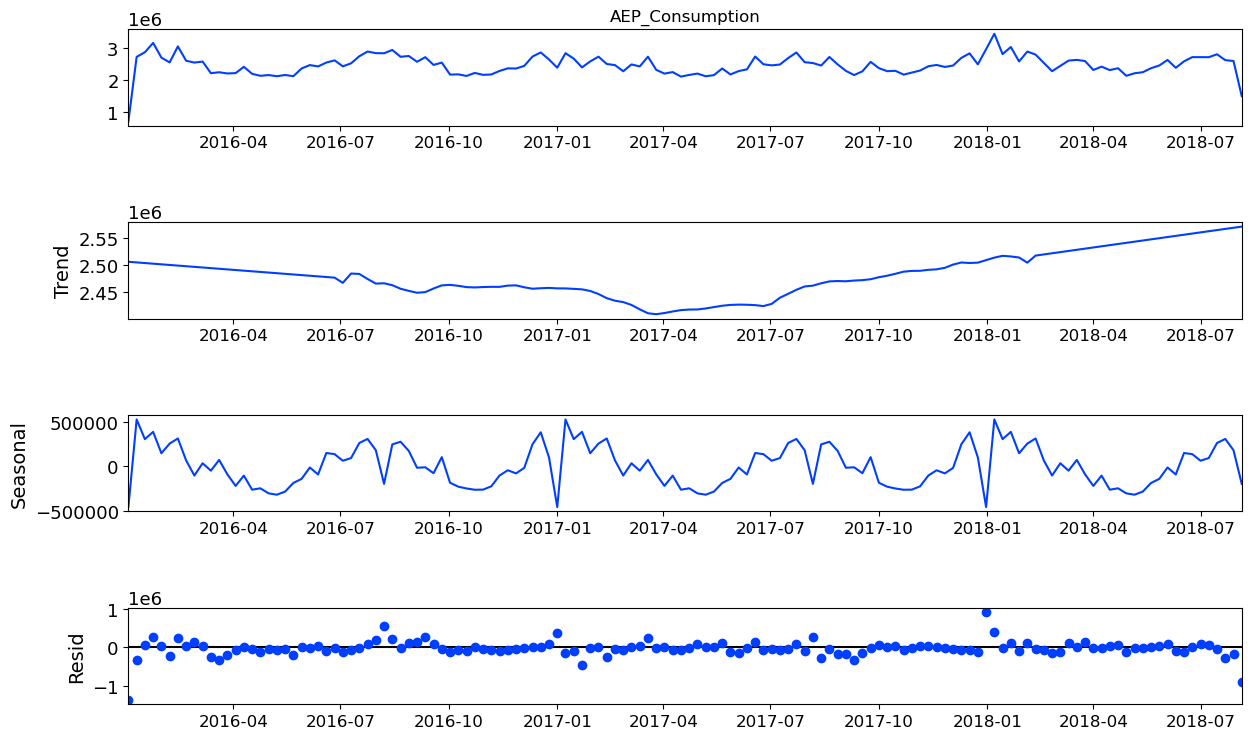

In [5]:
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(15,8)
    plt.show()
seasonal_decompose (y)

In [6]:
def test_stationarity(timeseries, title):
    
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    

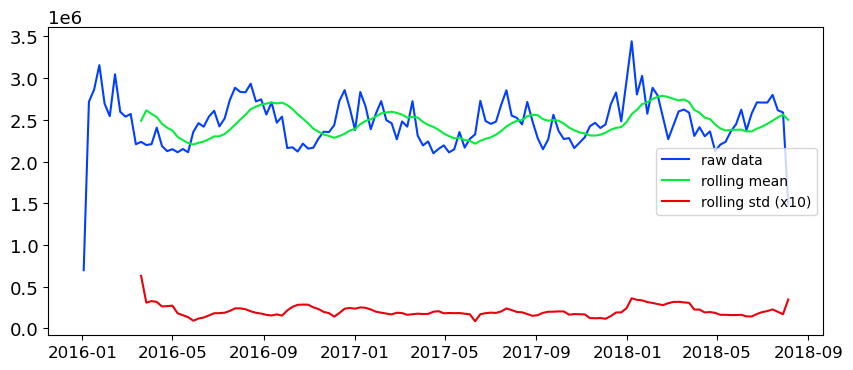

In [7]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [8]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print(dftest)
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [9]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
(-4.372253346189326, 0.0003322546023868391, 6, 129, {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}, 3328.395719170195)
Test statistic = -4.372
P-value = 0.000
Critical values :
	1%: -3.482087964046026 - The data is  stationary with 99% confidence
	5%: -2.8842185101614626 - The data is  stationary with 95% confidence
	10%: -2.578864381347275 - The data is  stationary with 90% confidence


 > Is the de-trended data stationary ?
(-5.633529502875399, 1.0759317898675917e-06, 9, 115, {'1%': -3.4885349695076844, '5%': -2.887019521656941, '10%': -2.5803597920604915}, 276.6523280065173)
Test statistic = -5.634
P-value = 0.000
Critical values :
	1%: -3.4885349695076844 - The data is  stationary with 99% confidence
	5%: -2.887019521656941 - The data is  stationary with 95% confidence
	10%: -2.5803597920604915 - The data is  stationary with 90% confidence


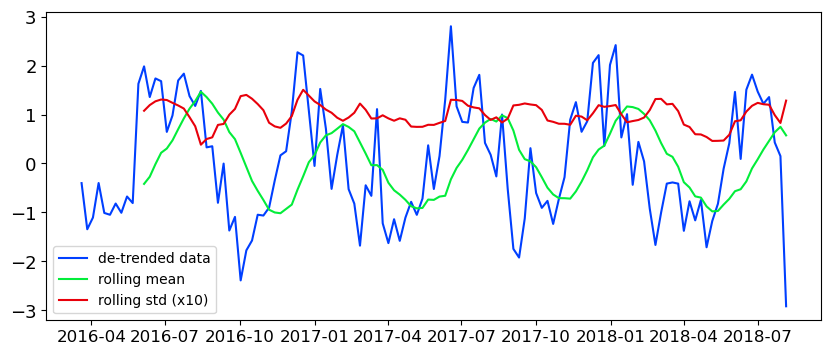

In [10]:
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()
test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the 12 lag differenced data stationary ?
(-5.834729947610218, 3.900520326096158e-07, 12, 111, {'1%': -3.490683082754047, '5%': -2.8879516565798817, '10%': -2.5808574442009578}, 3041.292641263773)
Test statistic = -5.835
P-value = 0.000
Critical values :
	1%: -3.490683082754047 - The data is  stationary with 99% confidence
	5%: -2.8879516565798817 - The data is  stationary with 95% confidence
	10%: -2.5808574442009578 - The data is  stationary with 90% confidence


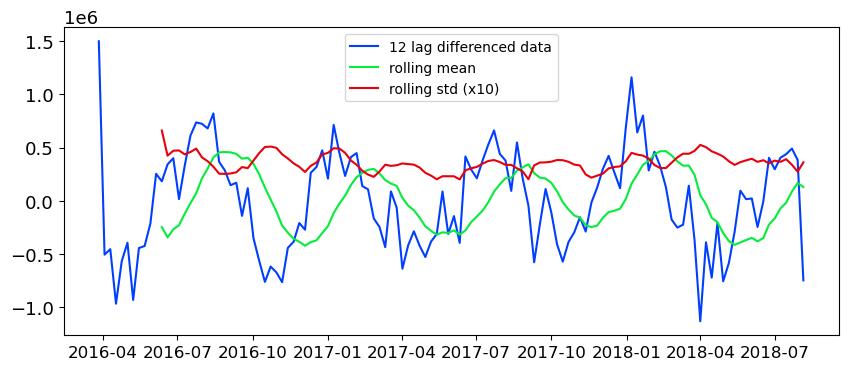

In [11]:
y_12lag =  y - y.shift(12)
test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

In [105]:
y_to_train = y[:'2018-2-25'] 
y_to_test = y['2018-2-26':]   
predict_date = len(y) - len(y[:'2018-2-26']) 
y_to_test

Date
2018-03-04    2434005
2018-03-11    2601847
2018-03-18    2624164
2018-03-25    2587593
2018-04-01    2307395
2018-04-08    2412266
2018-04-15    2303668
2018-04-22    2362015
2018-04-29    2126357
2018-05-06    2204680
2018-05-13    2238005
2018-05-20    2363166
2018-05-27    2448118
2018-06-03    2622242
2018-06-10    2376050
2018-06-17    2578147
2018-06-24    2710648
2018-07-01    2707591
2018-07-08    2707980
2018-07-15    2799780
2018-07-22    2616533
2018-07-29    2588782
2018-08-05    1488102
Freq: W-SUN, Name: AEP_Consumption, dtype: int64

In [13]:
def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='red', legend=True, figsize=(20, 10))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))

    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()
    

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 292926.31
The Root Mean Squared Error of our forecasts with auto optimization is 302875.21


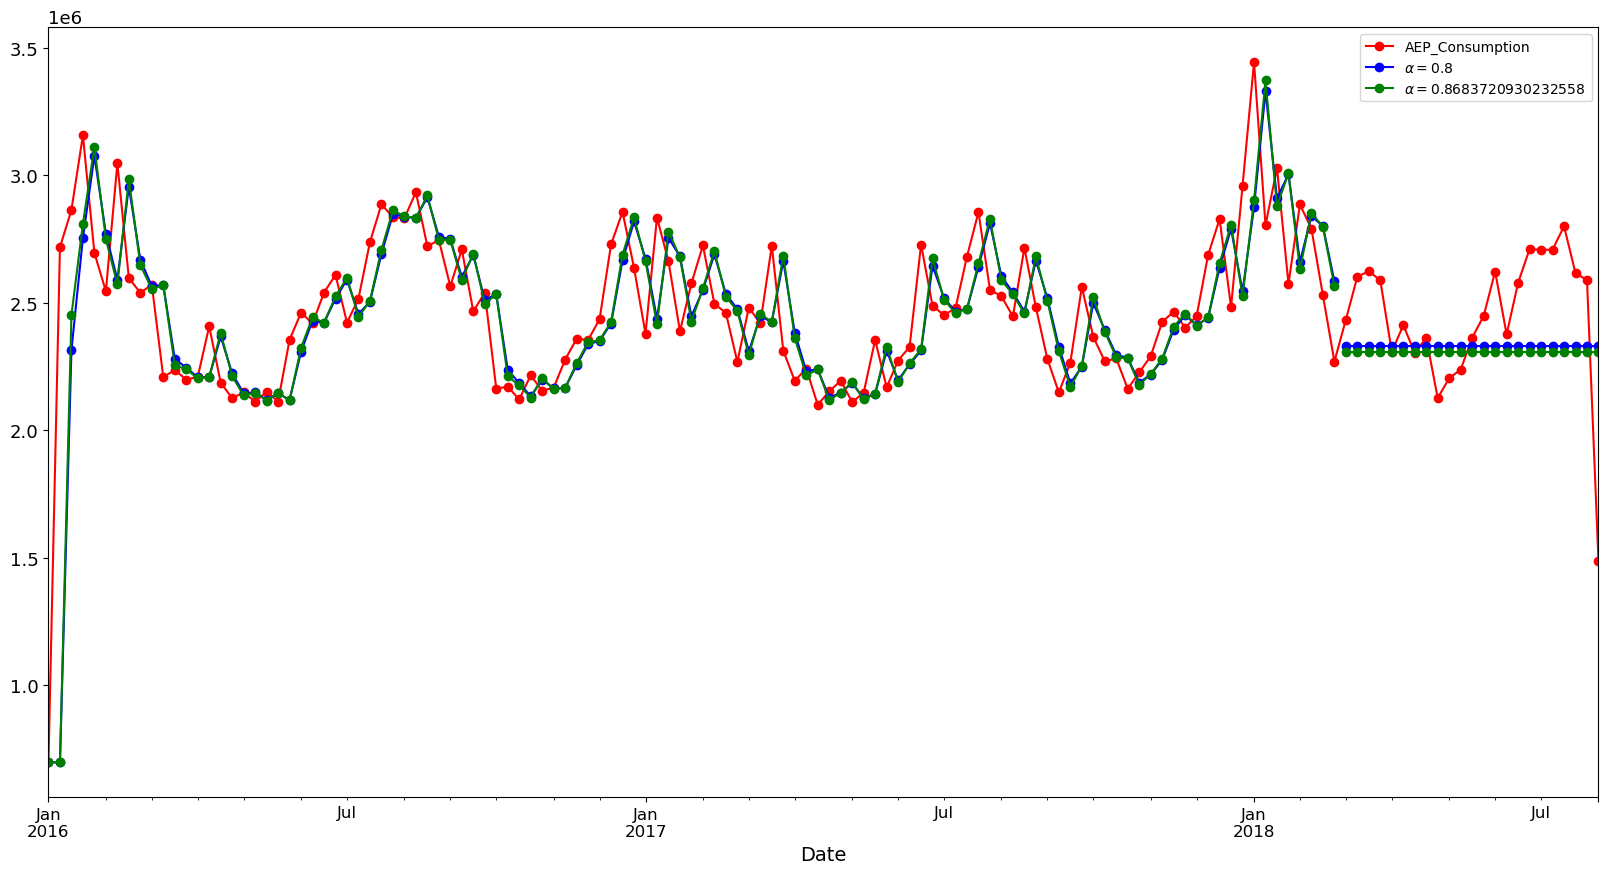

In [14]:
ses(y, y_to_train,y_to_test,0.8,predict_date)

In [15]:
def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='red', legend=True, figsize=(20, 10))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")    
    fit2.fittedvalues.plot(marker="o", color='green')
    fcast2.plot(color='green', marker="o", legend=True)
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    plt.show()

The Root Mean Squared Error of Holts Linear trend 1113681.16
The Root Mean Squared Error of Holts Exponential trend 794104.45


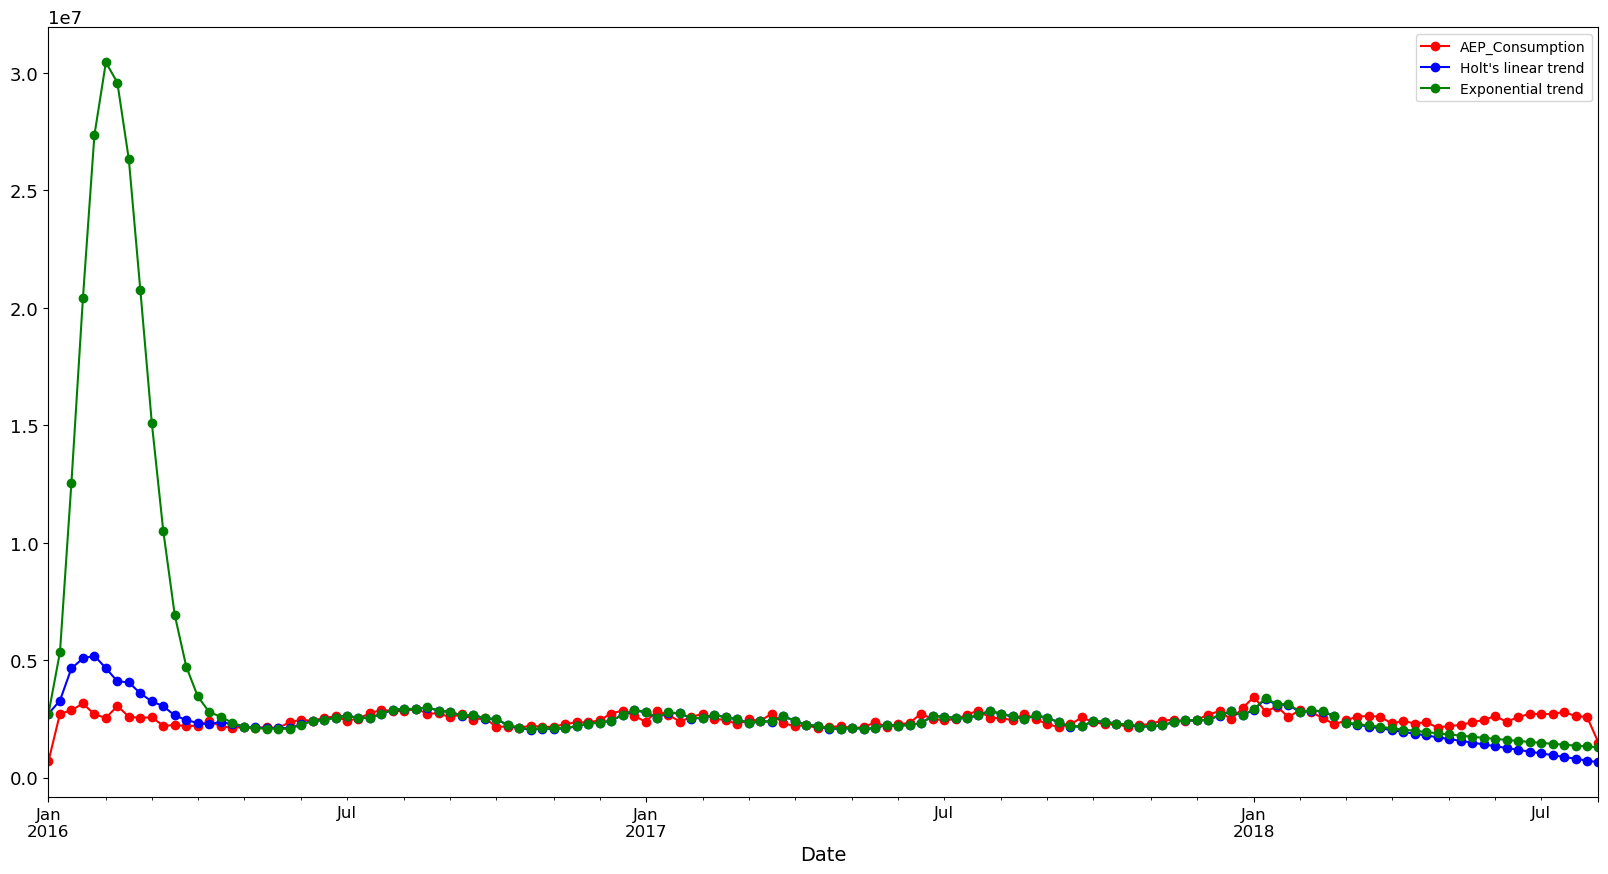

In [16]:
holt(y, y_to_train,y_to_test,0.6,0.2,predict_date)

In [45]:
def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='red', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit()
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit()
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='blue')
        fcast1.plot(style='--', marker='o', color='blue', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='mul', seasonal='mul').fit()
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='mul', seasonal='mul', damped=True).fit()
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='blue')
        fcast3.plot(style='--', marker='o', color='blue', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=52 and a Box-Cox transformation 360561.8
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=52 and a Box-Cox transformation 343696.51


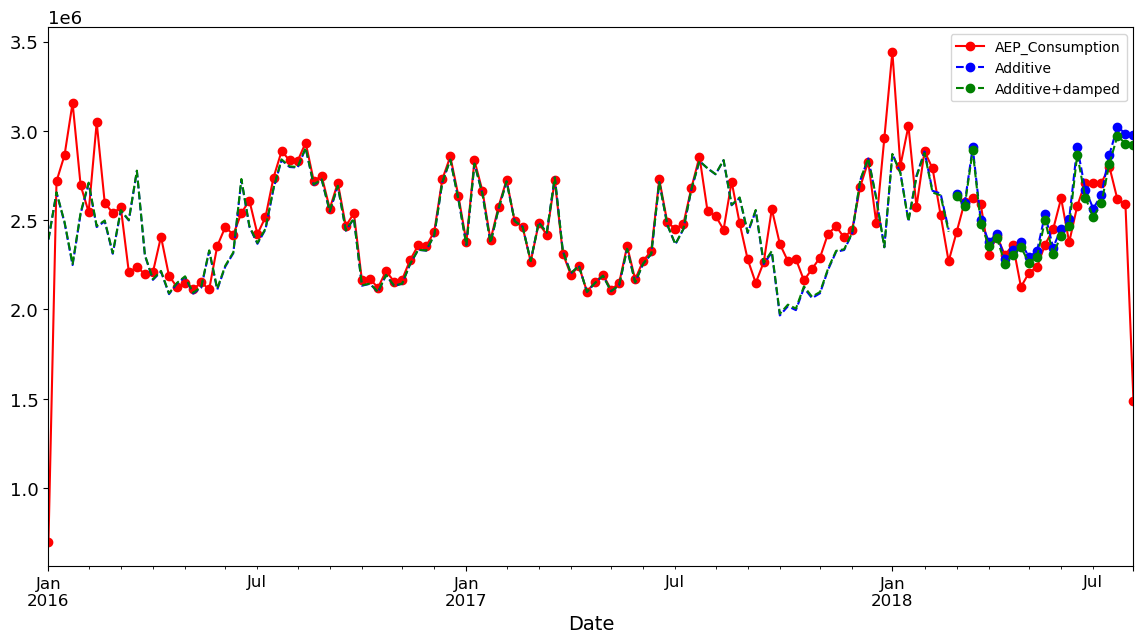

In [46]:
holt_win_sea(y, y_to_train,y_to_test,'additive',52, predict_date)

The Root Mean Squared Error of additive trend, multiplicative seasonal of period season_length=52 and a Box-Cox transformation 373800.55
The Root Mean Squared Error of additive damped trend, multiplicative seasonal of period season_length=52 and a Box-Cox transformation 373800.55


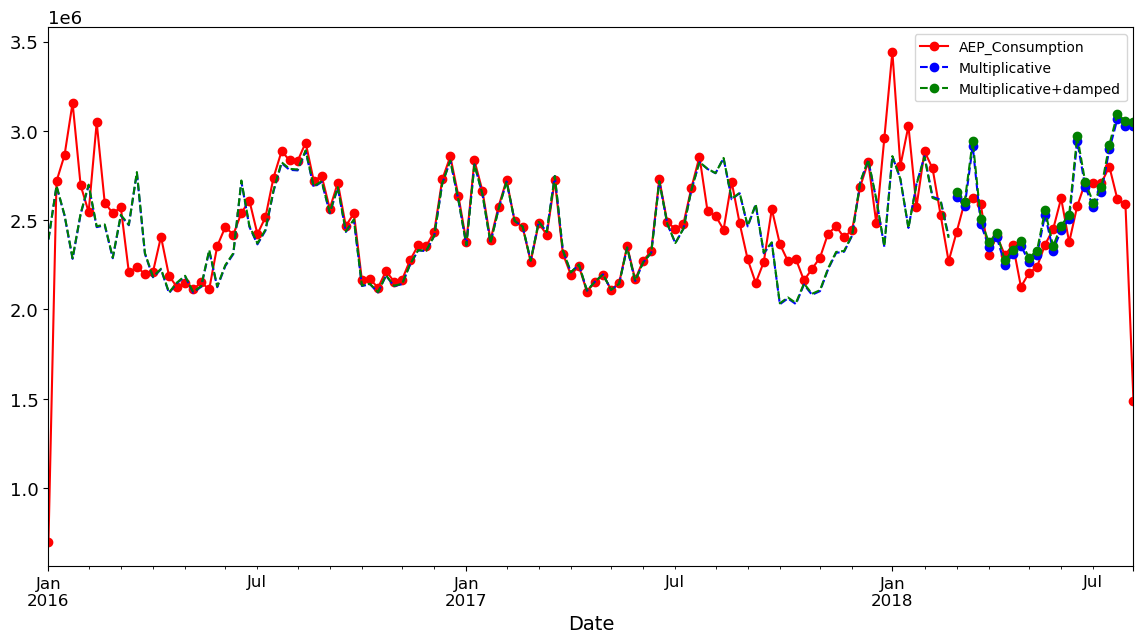

In [47]:
holt_win_sea(y, y_to_train,y_to_test,'multiplicative',52, predict_date)

In [50]:
def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    mini = float('+inf')
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

                    print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [51]:
sarima_grid_search(y,52)

SARIMA(0, 0, 0)x(0, 0, 0, 52) - AIC:4361.65831219095
SARIMA(0, 0, 0)x(0, 0, 1, 52) - AIC:3966.549634959742
SARIMA(0, 0, 0)x(0, 1, 0, 52) - AIC:2309.9184599880473
SARIMA(0, 0, 0)x(0, 1, 1, 52) - AIC:873.3021077787995
SARIMA(0, 0, 0)x(1, 1, 1, 52) - AIC:871.9748375649018
SARIMA(0, 0, 1)x(0, 1, 1, 52) - AIC:843.3776935402396
SARIMA(0, 0, 1)x(1, 1, 1, 52) - AIC:841.9746424301698
SARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:810.1968768769171
SARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:808.8252175994589
The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:808.8252175994589


In [123]:
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):

    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()

    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5931      0.637     -0.932      0.351      -1.841       0.654
ma.L1          0.4375      0.699      0.626      0.531      -0.933       1.808
ma.S.L52      -0.7535      0.148     -5.074      0.000      -1.045      -0.462
sigma2      6.345e+10   4.36e-12   1.46e+22      0.000    6.35e+10    6.35e+10


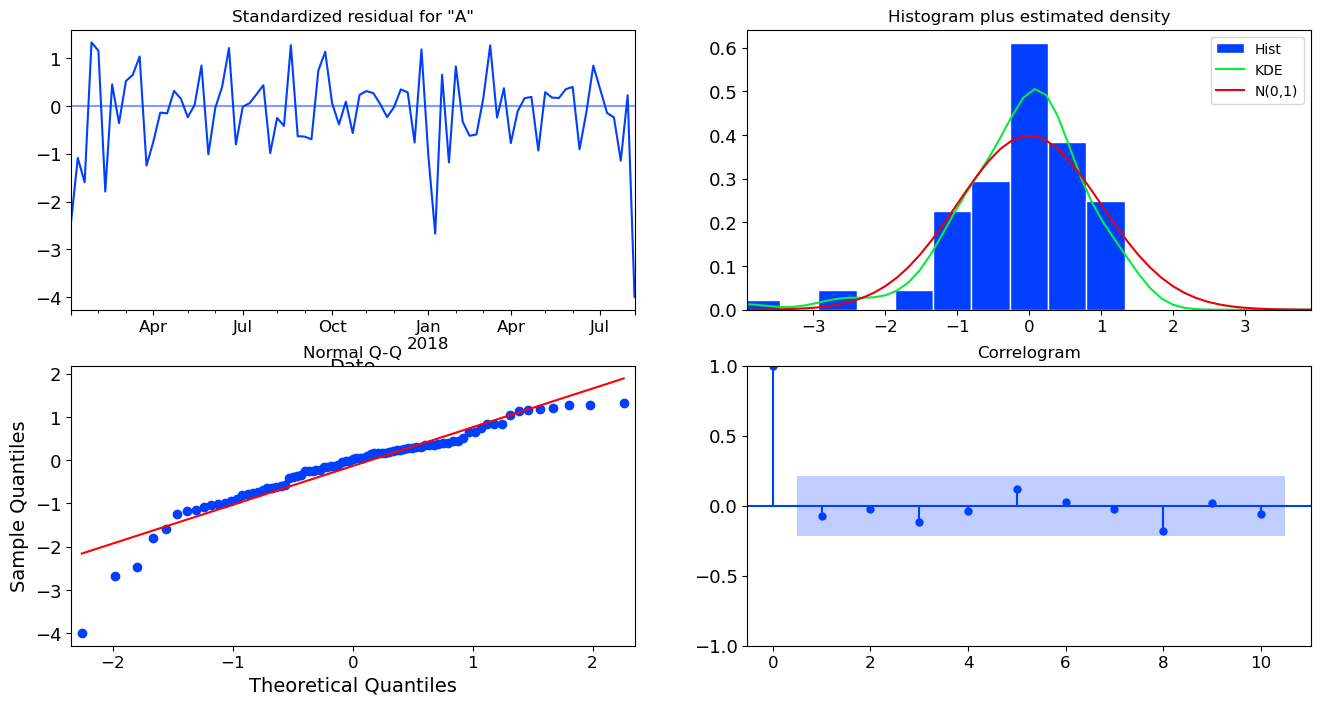

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 263122.77


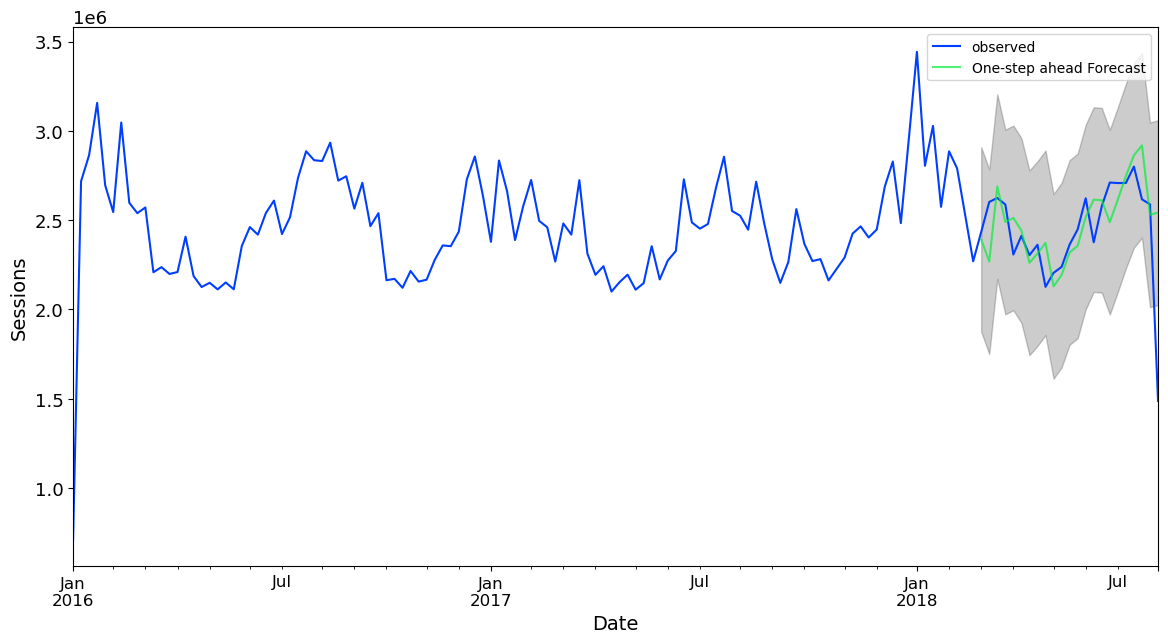

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 312084.44


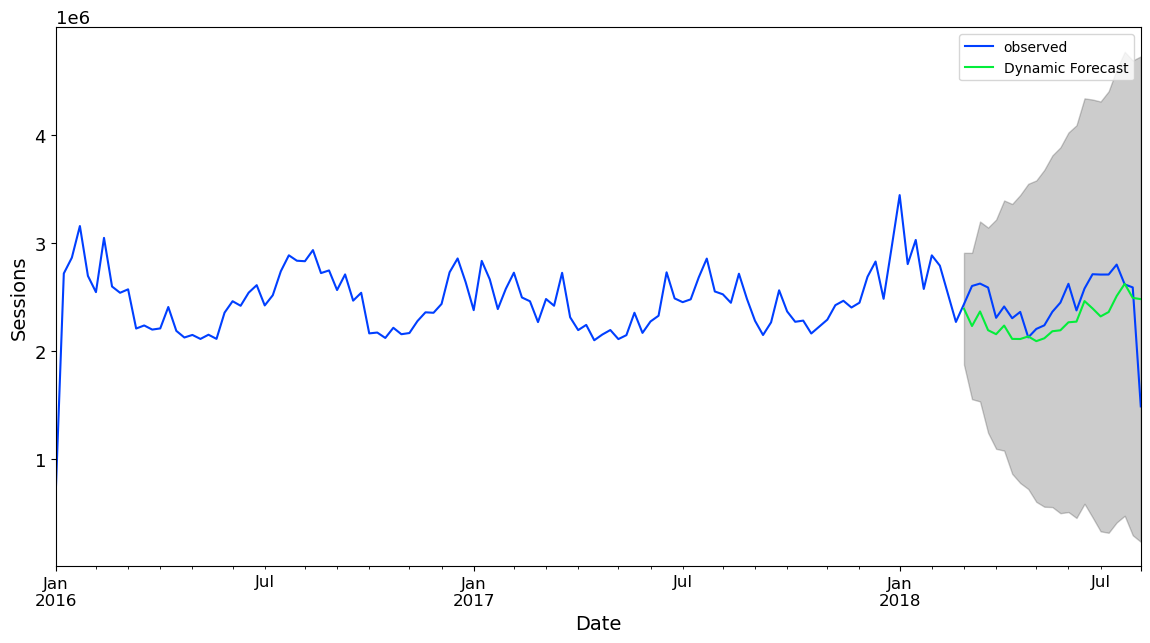

In [124]:
model = sarima_eva(y,(1, 1, 1),(0, 1, 1, 52),52,'2018-03-04',y_to_test)

In [125]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))

    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()

    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

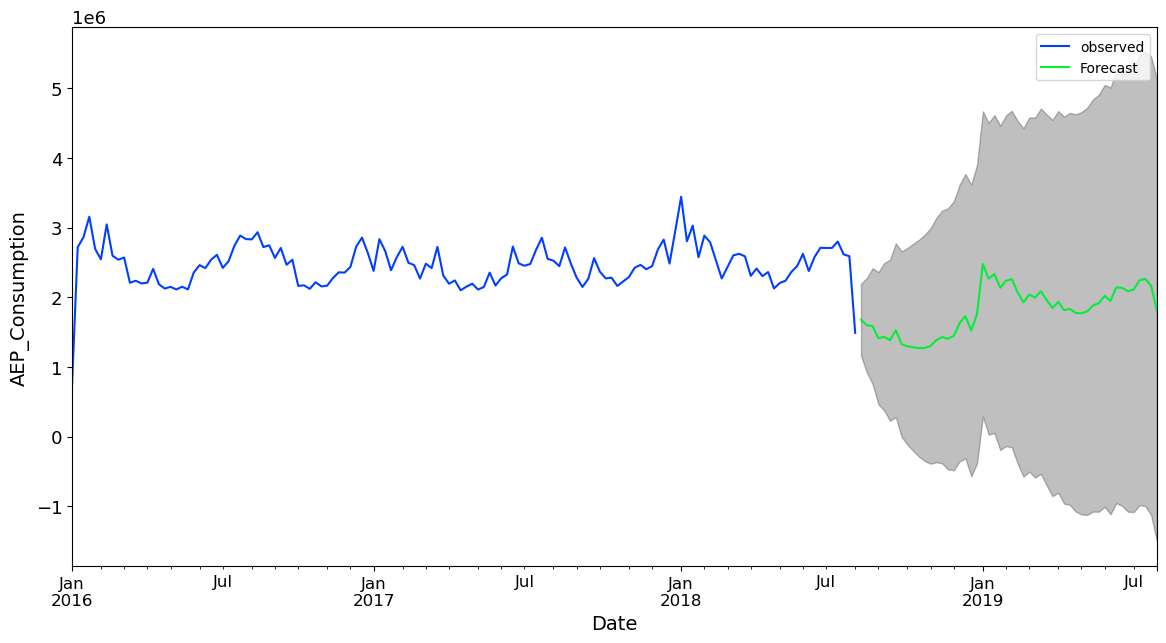

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2018-08-12,1676958.24397044,1159893.12139483,2194023.36654605
1,2018-08-19,1599074.69862473,922333.86864646,2275815.52860299
2,2018-08-26,1584573.25964333,752377.67707609,2416768.84221057
3,2018-09-02,1411406.68653165,462457.62160917,2360355.75145412
4,2018-09-09,1431832.81448760,371619.48269716,2492046.14627805


In [126]:
final_table = forecast(model,52,y)
final_table.head()

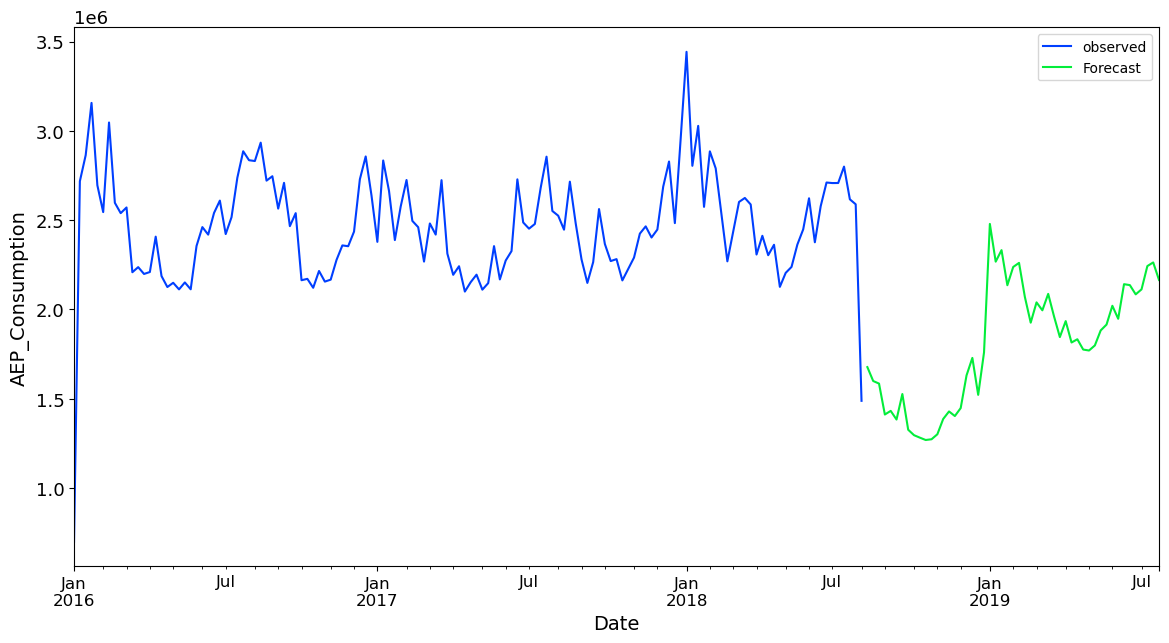

In [128]:
pred_uc = model.get_forecast(steps=52)
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)
plt.legend()
plt.show()

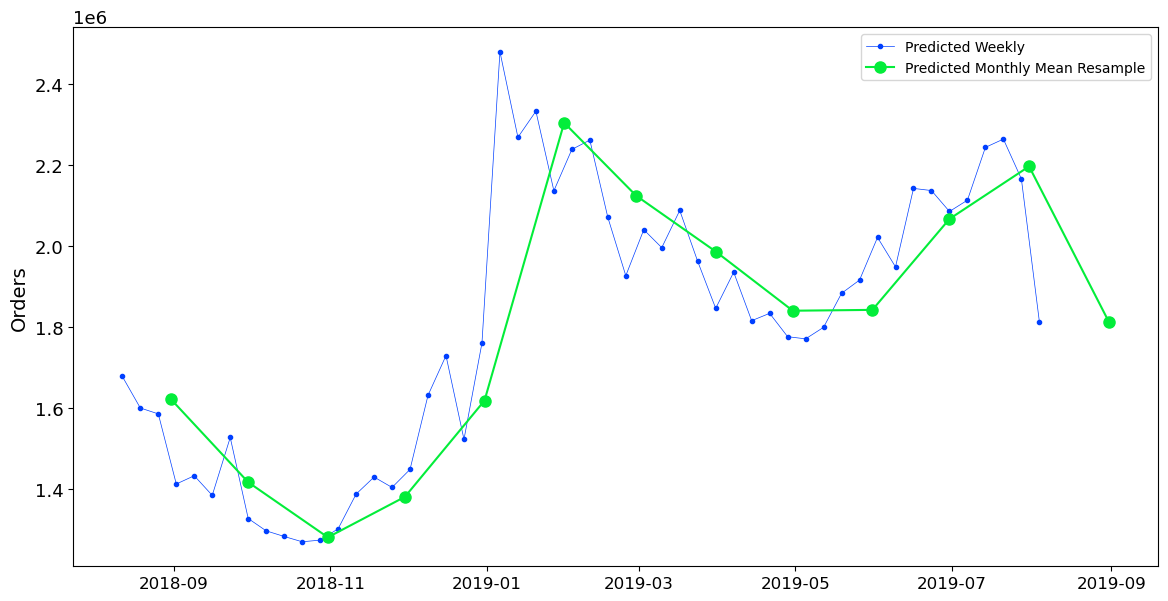

In [129]:
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(14, 7))
ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Weekly')
ax.plot(final_table.Predicted_Mean.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();